In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, gmean, cauchy
import seaborn as sns
from datetime import datetime, timedelta

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [3]:
length = 90 # Length of the output sequences (in number of timesteps)

In [4]:
def import_stock_data(tickers, start_date, end_date = datetime.today()):  
    if len([tickers]) == 1:
        # Import get_history function from nsepy module
        from nsepy import get_history

        data = get_history(symbol=tickers[0],
                        start=start_date,
                        end=end_date,
                        futures=False,
                        index=True)
    return(data)

In [5]:
end = datetime.today()
start = end - timedelta(days=length*2)

In [6]:
data = import_stock_data(['NIFTY'], start_date=start, end_date=end)

In [7]:
data.describe()

,Open,High,Low,Close,Volume,Turnover
count,126.000000,126.000000,126.000000,126.000000,1.260000e+02,1.260000e+02
mean,12923.219444,12987.894048,12819.571032,12913.230556,6.247619e+08,3.519497e+11
std,1311.361669,1318.252182,1302.971860,1314.725975,1.563274e+08,8.848450e+10
min,10910.400000,11015.300000,10790.200000,10805.550000,1.078681e+08,5.189380e+10
25%,11678.650000,11745.350000,11570.575000,11664.087500,5.285029e+08,2.945594e+11
50%,12883.275000,12955.925000,12793.750000,12866.625000,6.099723e+08,3.440096e+11
75%,13992.300000,14123.425000,13934.662500,14009.362500,7.057664e+08,3.909870e+11
max,15371.450000,15431.750000,15243.400000,15314.700000,1.371789e+09,7.852293e+11


In [8]:
data.isnull().sum()

Open        0
High        0
Low         0
Close       0
Volume      0
Turnover    0
dtype: int64

In [9]:
data = data.tail(90+1)

In [10]:
data.describe()

,Open,High,Low,Close,Volume,Turnover
count,91.000000,91.000000,91.000000,91.000000,9.100000e+01,9.100000e+01
mean,13484.854396,13553.154396,13376.366484,13478.853297,6.226938e+08,3.614590e+11
std,1105.256885,1110.081141,1099.152345,1102.508003,1.555422e+08,9.287723e+10
min,11633.300000,11725.650000,11535.450000,11642.400000,1.078681e+08,5.189380e+10
25%,12691.375000,12755.450000,12616.275000,12734.550000,5.306184e+08,3.043790e+11
50%,13547.200000,13597.500000,13447.050000,13558.150000,6.186315e+08,3.517592e+11
75%,14463.550000,14494.650000,14286.825000,14359.575000,7.061619e+08,4.033508e+11
max,15371.450000,15431.750000,15243.400000,15314.700000,1.162361e+09,7.852293e+11


In [11]:
data.tail()

,Open,High,Low,Close,Volume,Turnover
Date,,,,,,
2021-02-15,15270.30,15340.15,15243.40,15314.70,455959720,2.895529e+11
2021-02-16,15371.45,15431.75,15242.20,15313.45,648545320,3.655003e+11
2021-02-17,15279.90,15314.30,15170.75,15208.90,504767226,3.407312e+11
2021-02-18,15238.70,15250.75,15078.05,15118.95,770629541,3.709399e+11
2021-02-19,15074.80,15144.05,14898.20,14981.75,712213821,3.741934e+11


In [14]:
data.drop(data.tail(1).index,inplace=True) # drop last n rows

In [15]:
data.tail()

,Open,High,Low,Close,Volume,Turnover
Date,,,,,,
2021-02-12,15186.20,15243.50,15081.00,15163.30,571808807,3.230424e+11
2021-02-15,15270.30,15340.15,15243.40,15314.70,455959720,2.895529e+11
2021-02-16,15371.45,15431.75,15242.20,15313.45,648545320,3.655003e+11
2021-02-17,15279.90,15314.30,15170.75,15208.90,504767226,3.407312e+11
2021-02-18,15238.70,15250.75,15078.05,15118.95,770629541,3.709399e+11


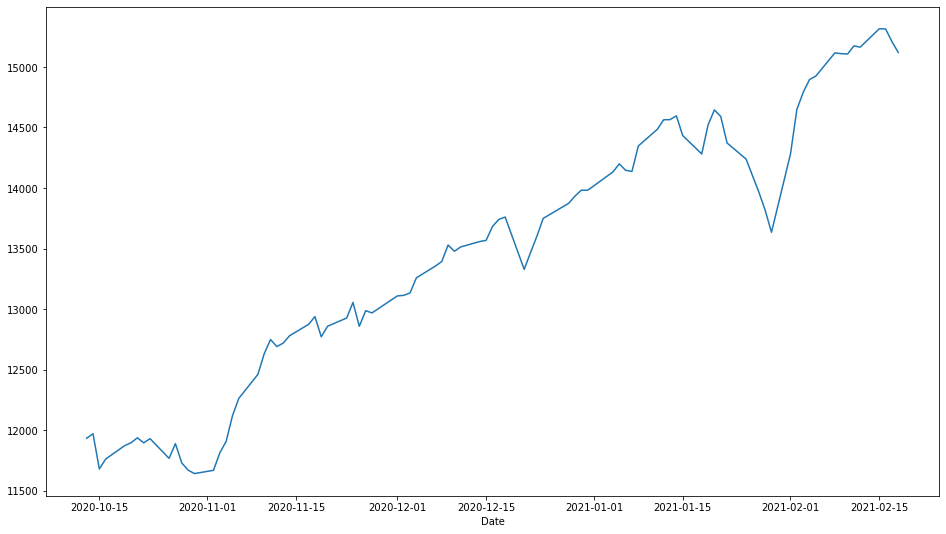

In [16]:
data['Close'].plot(figsize=(16,9))

In [17]:
data.drop(columns=['Turnover'], inplace = True)

In [18]:
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-10-13,11934.65,11988.20,11888.90,11934.50,458304851
2020-10-14,11917.40,11997.20,11822.15,11971.05,569245407
2020-10-15,12023.45,12025.45,11661.30,11680.35,608865041
2020-10-16,11727.40,11789.75,11667.85,11762.45,555764762
2020-10-19,11879.20,11898.25,11820.40,11873.05,541420990


In [19]:
import joblib
sc = joblib.load('scaler.gz')

In [20]:
training_set_scaled = sc.transform(data[['Open', 'High', 'Low', 'Close', 'Volume']])

In [21]:
len(training_set_scaled)

90

In [22]:
model = tf.keras.models.load_model('my_h5_model.h5')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 50)            11200     
_________________________________________________________________
dropout (Dropout)            (None, 90, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 90, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 90, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [27]:
training_set_scaled.shape

(90, 5)

In [28]:
training_set_scaled = np.expand_dims(training_set_scaled, axis=0)

In [29]:
training_set_scaled.shape

(1, 90, 5)

In [30]:
score = model.predict(training_set_scaled)

In [37]:
score.sum()

0.99999994

In [50]:
np.set_printoptions(suppress=True)
print(score)

[[0.001 0.998 0.001]]


If first number is big, market will go up by 3%

If middle number is big, market will go down by 3%

If last number is big, market will not move up or down by 3%